In [1]:
import numpy as np
import _pickle as pkl
import torch
import torch.nn as nn
%matplotlib inline 
import matplotlib.pyplot as plt
import os, sys, time
sys.path.append('../..')
from utils import set_seed_torch, rgb2gray, load_vh_models, frame_stack
set_seed_torch(3)
from train import encode
from argparse import Namespace
import json
import gzip

In [2]:
class ObjectView(object):
    def __init__(self, d): self.__dict__ = d
        
args = ObjectView({
 'res': 64,
 'dataset_path': ['/home/olimoyo/visual-haptic-dynamics/experiments/data/datasets/{}'
                   .format("vha1_2D_len16_oscxy_withGT_0B7AB071F98942578ABDA66879290F2F.pkl"),
                  '/home/olimoyo/visual-haptic-dynamics/experiments/data/datasets/{}'
                   .format("vha2_2D_len16_oscxy_withGT_3502DE81F7C343FB8B57FA92FDECF4DA.pkl"),
                  '/home/olimoyo/visual-haptic-dynamics/experiments/data/datasets/{}'
                   .format("vha3_2D_len16_oscxy_withGT_5DB32B21A6AA4E5892D2F6B8F40EF9E6.pkl")
                 ],
 'models_dir': '/home/olimoyo/visual-haptic-dynamics/saved_models/{}'
                   .format("vh"),
#  'dataset_path': ['/home/olimoyo/visual-haptic-dynamics/experiments/data/datasets/mit_push/{}'
#                    .format("min-tr2.5_min-rot0.5_len48.pkl")
#                  ],
#  'models_dir': '/home/olimoyo/visual-haptic-dynamics/saved_models/{}'
#                    .format("mit"),
 'device': 'cuda:1',
 'n_examples': 32,
 'n_pred': 12,
 'n_initial': 2
})

def load_models_dir(models_dir):
    """Load hyperparameters from trained model."""
    dict_of_models = {}
    for filedir in os.listdir(models_dir):
        fullpath = os.path.join(models_dir, filedir)
        if os.path.isdir(fullpath):
            with open(os.path.join(fullpath, 'hyperparameters.txt'), 'r') as fp:
                dict_of_models[fullpath] = Namespace(**json.load(fp))
    return dict_of_models

def is_gz_file(filepath):
    with open(filepath, 'rb') as test_f:
        return test_f.read(2) == b'\x1f\x8b'
    
data = {
#     'img_rgb': [],
    'img_gray': [],
    'haptic': [],
    'arm': [],
    'actions': [],
    'gt_plate_pos': []
}

for dataset_path in args.dataset_path:
    if is_gz_file(dataset_path):
        with gzip.open(dataset_path, 'rb') as f:
            raw_data = pkl.load(f)
    else:
        with open(dataset_path, 'rb') as f:
            raw_data = pkl.load(f)

#     data['img_rgb'].append(torch.from_numpy(raw_data["img"].transpose(0, 1, 4, 2, 3)).int().to(device=args.device))
    data['img_gray'].append(torch.from_numpy(rgb2gray(raw_data['img']).transpose(0, 1, 4, 2, 3)).float().to(device=args.device))
    data['haptic'].append(torch.from_numpy(raw_data['ft']).float().to(device=args.device))
    data['arm'].append(torch.from_numpy(raw_data['arm']).float().to(device=args.device))
    data['actions'].append(torch.from_numpy(raw_data['action']).to(device=args.device).float())
    data['gt_plate_pos'].append(torch.from_numpy(raw_data['gt_plate_pos']).to(device=args.device).float())
data = {k:torch.cat(v, dim=0) for k,v in data.items()}

Loading models in path:  /home/olimoyo/visual-haptic-dynamics/saved_models/vh/1465883_nstep2_reproduce_1024optbase_noAnnealkl_yesWN_noBN_yeslearnuncertainty_notraininit_z16_net256_l0_lm_osc_vha_r1.00_kl1.00_lr3e4


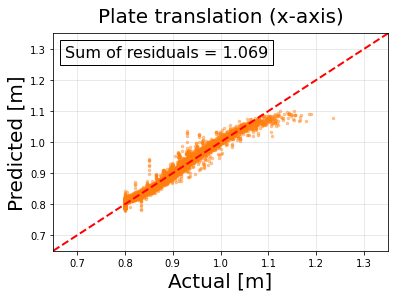

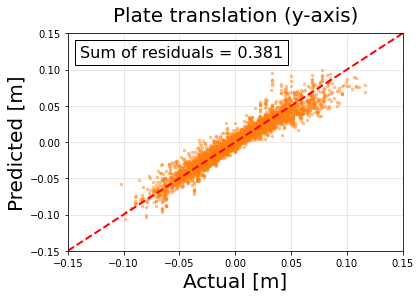

Loading models in path:  /home/olimoyo/visual-haptic-dynamics/saved_models/vh/1485221_nstep2_1024optbase_noAnnealkl_yesWN_noBN_yeslearnuncertainty_notraininit_z16_net256_l0_lm_osc_va_r1.00_kl1.00_lr3e4


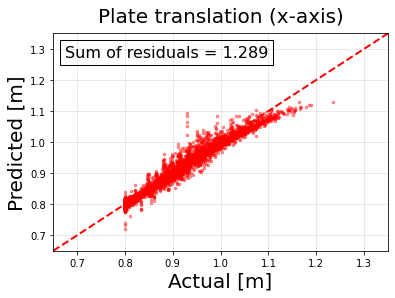

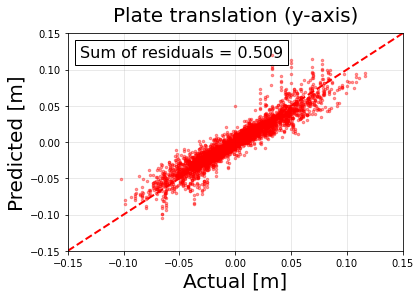

Loading models in path:  /home/olimoyo/visual-haptic-dynamics/saved_models/vh/1485220_nstep2_1024optbase_noAnnealkl_yesWN_noBN_yeslearnuncertainty_notraininit_z16_net256_l0_lm_osc_vh_r1.00_kl1.00_lr3e4


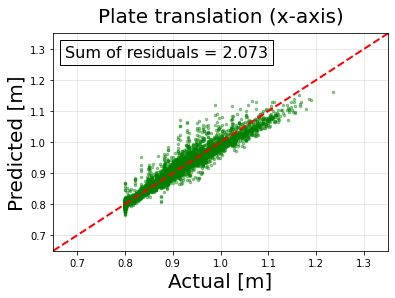

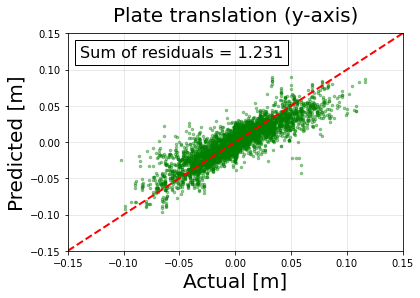

Loading models in path:  /home/olimoyo/visual-haptic-dynamics/saved_models/vh/1465882_nstep2_reproduce_1024optbase_noAnnealkl_yesWN_noBN_yeslearnuncertainty_notraininit_z16_net256_l0_lm_osc_v_r1.00_kl1.00_lr3e4


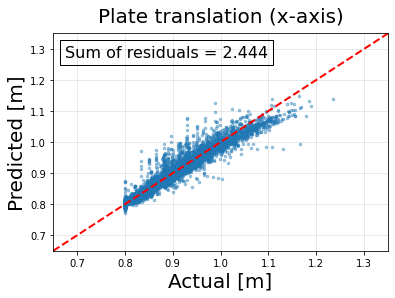

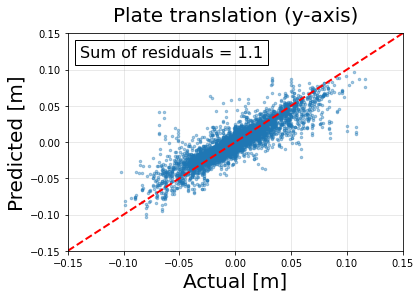

In [3]:
dict_of_models = load_models_dir(args.models_dir)

with torch.no_grad():
    for path, model_args in dict_of_models.items():
        nets = load_vh_models(path=path, args=model_args, mode='eval', device=args.device)

        # Use validation indices only
        with open(os.path.join(path, "val_idx.pkl"), 'rb') as f:
            val_idx = pkl.load(f)
        data_val = {k:v[val_idx] for k,v in data.items()}
        
#         if model_args.dim_x[0] == 1:
#             img_key = 'img_gray'
#         elif model_args.dim_x[0] == 3:
#             img_key = 'img_rgb'
        img_key = 'img_gray'
        n_val = data_val[img_key].shape[0]
    
        T = model_args.frame_stacks
        
        assert args.n_initial + args.n_pred <= data_val[img_key].shape[1]
        assert args.n_initial > T

        z_hat = torch.zeros(((args.n_initial + args.n_pred - T), n_val, model_args.dim_z)).to(device=args.device)

        # Use a random batch to test
        for ii in range(n_val // args.n_examples):
            batch_range = range(args.n_examples*ii, args.n_examples*(ii+1))
            test_batch = {k:v[batch_range] for k,v in data_val.items()}

            # Set up data for batch
            x_img = test_batch[img_key][:, :(args.n_initial + args.n_pred)]
            x_ft = test_batch['haptic'][:, :(args.n_initial + args.n_pred)]
            x_arm = test_batch['arm'][:, :(args.n_initial + args.n_pred)]
            u = test_batch['actions']
            x_i = {}
            
            # Sequence of initial images
            x_img_i = x_img[:, :args.n_initial]
            x_img_i = frame_stack(x_img_i, frames=T)
            n, l = x_img_i.shape[0], x_img_i.shape[1] 
            x_i["img"] = x_img_i
        
            # Sequence of extra modalities
            x_ft_i = x_ft[:, :args.n_initial] / model_args.ft_normalization
            x_arm_i = x_arm[:, :args.n_initial]
            u_i = u[:, T:args.n_initial]

            if model_args.context_modality != "none":
                if model_args.context_modality == "joint":
                    x_i["context"] = torch.cat((x_ft_i, x_arm_i), dim=-1)
                elif model_args.context_modality == "ft":
                    x_i["context"] = x_ft_i
                elif model_args.context_modality == "arm":
                    x_i["context"] = x_arm_i

                if model_args.use_context_frame_stack:
                    x_i['context'] = frame_stack(x_i['context'], frames=T)
                else:
                    x_i["context"] = x_i["context"][:, T:]
                x_i["context"] = x_i["context"].transpose(-1, -2)

            x_i = {k:v.reshape(-1, *v.shape[2:]) for k, v in x_i.items()}

            # Encode
            if model_args.use_prior_expert:
                q_z_i, _ = encode(nets, model_args, x_i, u_i, device=args.device)
            else:
                q_z_i = encode(nets, model_args, x_i, u_i, device=args.device)
            
            # Group and prepare for prediction
            q_z_i = {k:v.reshape(n, l, *v.shape[1:]).transpose(1,0) for k, v in q_z_i.items()}
            u = u.transpose(1,0)
            
            z_hat[0:l, batch_range] = q_z_i["mu"]

            # First run
            z_i, mu_z_i, var_z_i = q_z_i["z"], q_z_i["mu"], q_z_i["cov"]
            u_i = u[(T + 1):(1 + args.n_initial)]
            h_i = None

            # Predict
            for jj in range(0, args.n_pred):
                z_ip1, mu_z_ip1, var_z_ip1, h_ip1 = nets["dyn"](
                    z_t=z_i, 
                    mu_t=mu_z_i, 
                    var_t=var_z_i, 
                    u=u_i, 
                    h_0=h_i, 
                    single=False
                )
                z_hat[jj + l, batch_range] = mu_z_ip1[-1]
                z_i, mu_z_i, var_z_i, h_i = z_ip1[-1:], mu_z_ip1[-1:], var_z_ip1[-1:], h_ip1
                u_i = u[1 + args.n_initial + jj][None]  
                
        # Plot regression lines
        X = z_hat.reshape(-1, *z_hat.shape[2:]).cpu().numpy()
        if np.size(list(data_val["gt_plate_pos"].shape)) > 3:
            plate_pos = data_val["gt_plate_pos"][:, T:(args.n_initial + args.n_pred), -1]
        else:
            plate_pos = data_val["gt_plate_pos"][:, T:(args.n_initial + args.n_pred)]
        y = plate_pos.transpose(0,1).reshape(-1, *plate_pos.shape[2:]).cpu().numpy()

        # Add column of 1s for intercept
        X = np.hstack((X, np.ones((X.shape[0], 1))))

        # Solve for parameters of OLS
        out = np.linalg.lstsq(X, y, rcond=None)
        w = out[0]
        res = out[1]
        
        # Predicted values
        y_hat = X @ w

        def regression_plot(y, y_hat, title, text, xlim, ylim, color): 
            assert y.shape == y_hat.shape
            n = y.shape[0]
            fig, ax = plt.subplots()
            ax.plot(y, y_hat, 'o', markersize=2.5, c=color, alpha=0.40)
            ax.grid(alpha=0.35, linestyle='solid', axis='both')
            ax.text(
                0.035, 
                0.89, 
                text, 
                size=16,
                color='black', 
                bbox=dict(facecolor='none', edgecolor='black', pad=5.0),
                transform = ax.transAxes
            )
            plt.xlim(xlim)
            plt.ylim(ylim)
            _ = plt.plot(ax.get_xlim(), ax.get_ylim(), lw=2, ls="--", c="r")
            plt.title(title, size=20, pad=12.0)
            plt.xlabel('Actual [m]', size=20)
            plt.ylabel('Predicted [m]', size=20)
            plt.show()

        if "_vha_" in path:
            color = '#ff7f0e'
        elif "_v_" in path:
            color = '#1f77b4'
        elif "_va_" in path:
            color = 'red'
        elif "_vh_" in path:
            color = 'green'
        
        regression_plot(
            y[:,0], 
            y_hat[:,0], 
            title="Plate translation (x-axis)",
            text=f"Sum of residuals = {round(res[0], 3)}", 
            xlim=(0.65, 1.35), 
            ylim=(0.65, 1.35),
            color=color
        )
        
        regression_plot(
            y[:,1], 
            y_hat[:,1], 
            title="Plate translation (y-axis)",
            text=f"Sum of residuals = {round(res[1], 3)}", 
            xlim=(-0.15,0.15), 
            ylim=(-0.15,0.15),
            color=color
        )